In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import scvi
import scanpy as sc
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import os
import torch
import sys
from datetime import datetime
import scarches as sca
from scipy.io import mmread

/bigdata/katepetrenko/miniconda3/lib/python3.12/site-packages/dask/array/chunk_types.py:110: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy-cuda11x, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  import cupy
/bigdata/katepetrenko/miniconda3/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'p

In [3]:
scvi.settings.progress_bar_style = "tqdm"
sc.set_figure_params(figsize=(4, 4), dpi=100, dpi_save=300)

nCores = 8
sc.settings.n_jobs = nCores
scvi.settings.num_threads = nCores

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    scvi.settings.seed = seed
    os.environ["PYTHONHASHSEED"] = str(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(123)

output_dir = "nba_integration/"
os.makedirs(output_dir, exist_ok=True)
output_tables = os.path.join(output_dir, "tables")
os.makedirs(output_tables, exist_ok=True)
output_figures = os.path.join(output_dir, "figures")
os.makedirs(output_figures, exist_ok=True)
sc.settings.figdir = output_figures

my_colors = [
    "#6495EDFF", "#FF69B4FF", "#BA55D3FF", "#F08080FF", "#32CD32FF",  
    "#9ACD32FF", "#4682B4FF", "#DDA0DDFF", "#FFA07AFF", "#8FBC8BFF",
    "#40E0D0FF", "#F0E68CFF", "#5F9EA0FF", "#D2B48CFF",  
    "#FFDAB9FF", "#87CEEBFF", "#B4A0E5", "#5BC0BE", "#773344", "#A4BEF3"
]

Seed set to 123


In [4]:
query = sc.read_h5ad("nba_integration/ATLAS_deepannotated.h5ad")

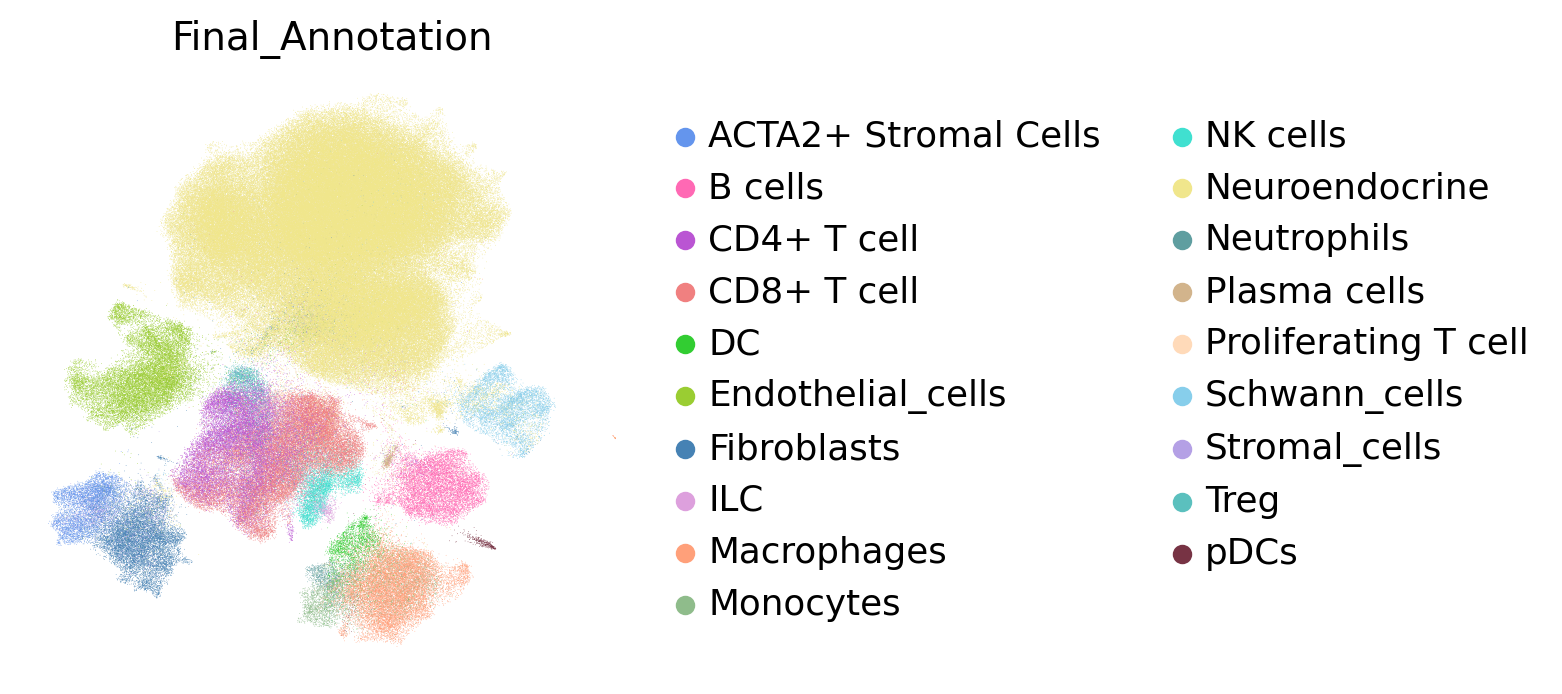

In [8]:
sc.pl.umap(
    query,
    color = ["Final_Annotation"],
    palette = my_colors,
    frameon=False,
    sort_order=False
)

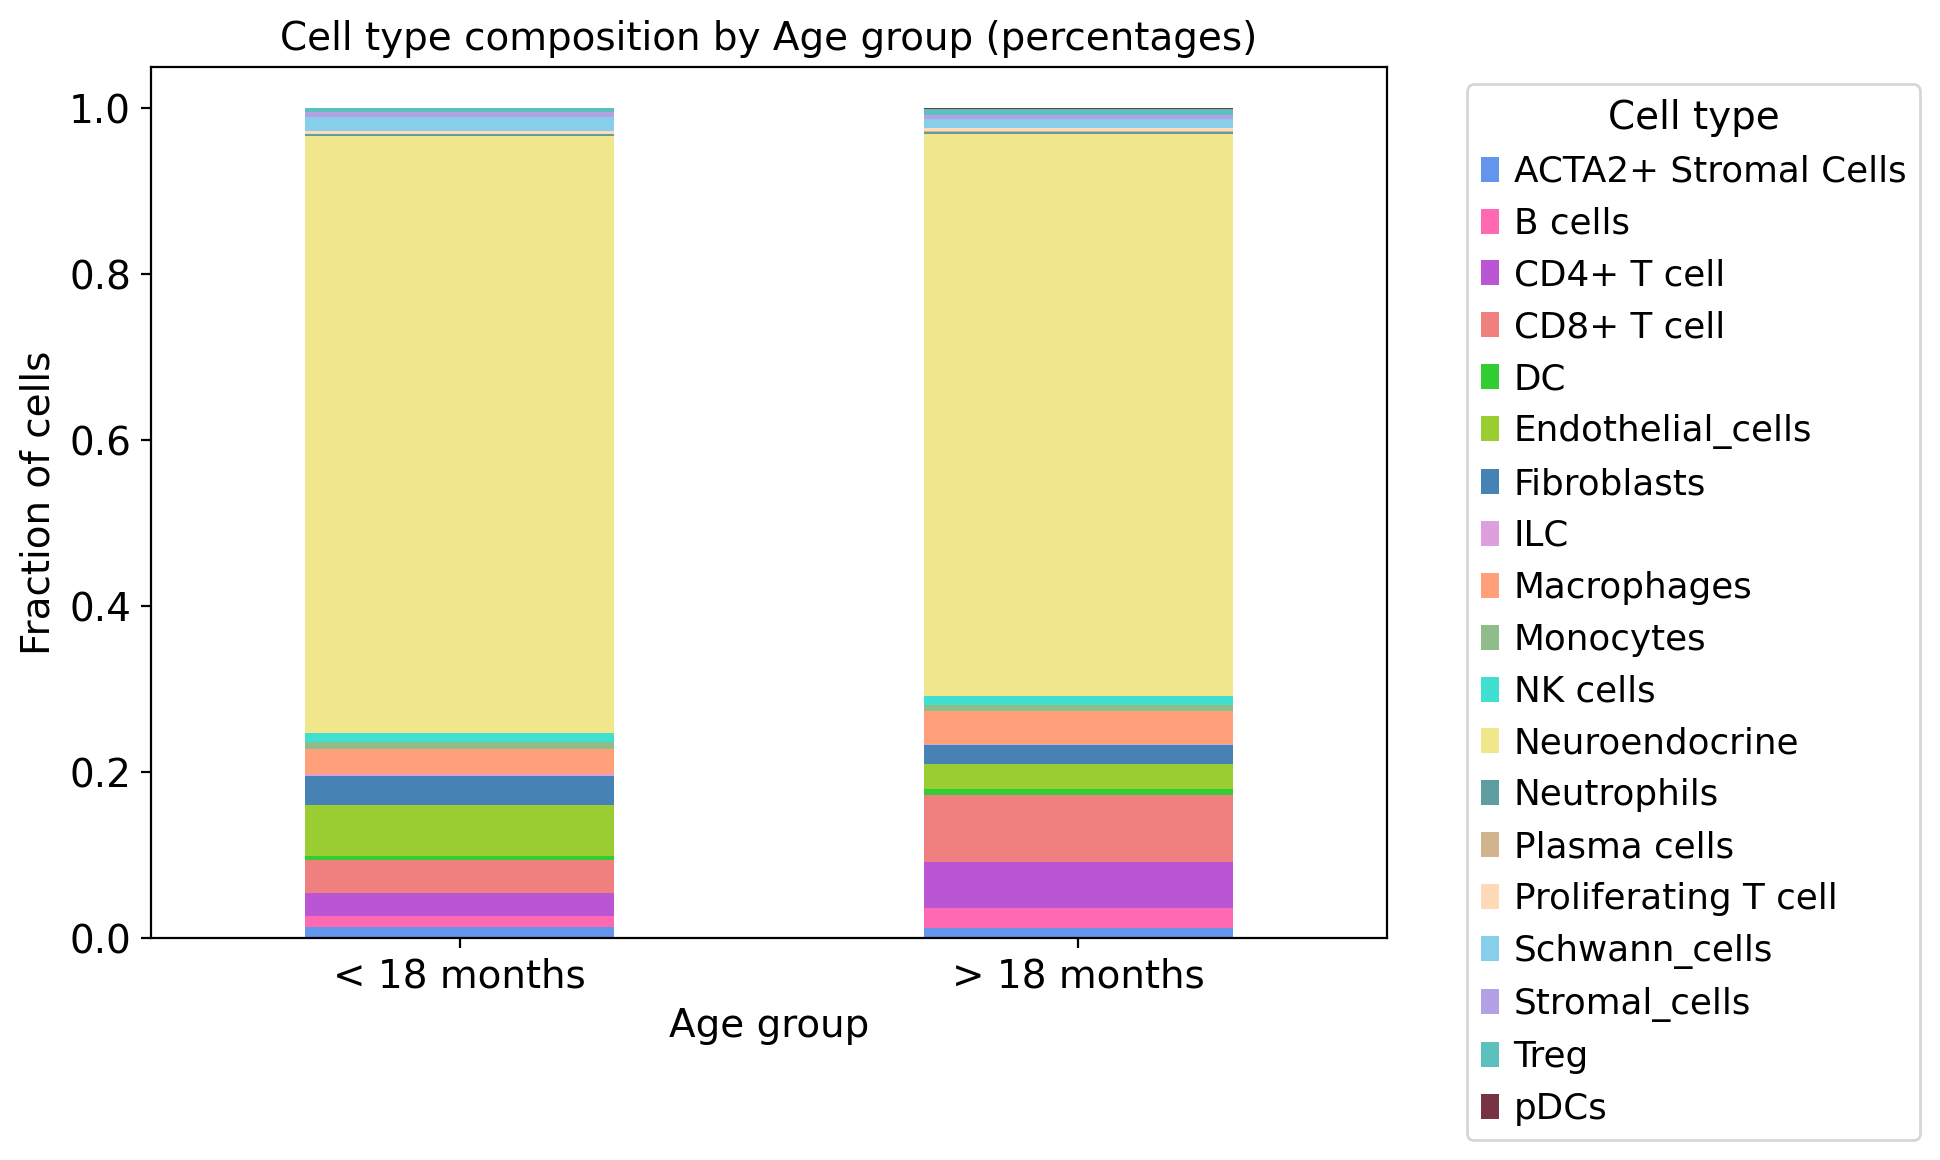

In [9]:
# Step 1: Group by Age and Cell Type, reshape to wide format
df = query.obs.groupby(["Age", "Final_Annotation"]).size().unstack(fill_value=0)

# Step 2: Normalize each row to get percentages
df_percent = df.div(df.sum(axis=1), axis=0)

# Optional: sort columns for consistency
df_percent = df_percent[sorted(df_percent.columns)]

# Check color list is long enough
if len(my_colors) < len(df_percent.columns):
    raise ValueError("Not enough colors for the number of cell types.")

# Step 4: Plot
df_percent.plot(
    kind="bar",
    stacked=True,
    color=my_colors[:len(df_percent.columns)],
    figsize=(10, 6)
)

plt.title("Cell type composition by Age group (percentages)")
plt.ylabel("Fraction of cells")
plt.xlabel("Age group")
plt.xticks(rotation=0)
plt.grid(False)
plt.legend(title="Cell type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## DAA

In [5]:
import pertpy as pt
import sccoda

In [6]:
query.obs['Study_method'] = query.obs['Study_method'].astype('category')

In [23]:
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(
    query,
    type="cell_level",
    generate_sample_level=True,
    cell_type_identifier="Final_Annotation",
    sample_identifier="SampleID",
    covariate_obs=["Age", "Study_method"],
)
sccoda_data

/bigdata/katepetrenko/miniconda3/lib/python3.12/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/bigdata/katepetrenko/miniconda3/lib/python3.12/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


MuData object with n_obs × n_vars = 453100 × 5019
  2 modalities
    rna:	452997 x 5000
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'SampleID', 'percent_mito', 'percent_ribo', 'complexity', 'scDblFinder.class', 'DoubletFinder.class', 'singlet', 'nCount_tmp', 'nFeature_tmp', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'celltype_humatlas_main', 'celltype_humatlas_fine', 'Immune_UCell', 'Lymphoid_UCell', 'PanBcell_UCell', 'Bcell_UCell', 'APC_UCell', 'Epithelial_UCell', 'Stromal_UCell', 'Myeloid_UCell', 'MoMacDC_UCell', 'Neutrophils_UCell', 'Tcell_UCell', 'NK_UCell', 'Endothelial_UCell', 'Talphabeta_UCell', 'Plasma_cell_UCell', 'CD4Tcell_UCell', 'Treg_UCell', 'CD8T_UCell', 'Tgammadelta_UCell', 'TAM_UCell', 'Tgd1_UCell', 'Tgd2_UCell', 'CD4T_UCell', 'Fibroblast_UCell', 'Alveolar_type1_UCell', 'Alveolar_type2_UCell', 'Keratinocyte_UCell', 'Melanocyte_UCell', 'Macrophage_UCell', 'Mast_UCell', 'pDC_UCell', 'cDC1_UCell', 'cDC2_UCell', 'cDC2b_UCell', 'DC3_UCell', 'Monocyte_UCell', 'Monocyte_not_cDC2_UCell', 'is.pure_Bcell', 'is.pure_CD4T', 'is.pure_CD8T', 'is.pure_Endothelial', 'is.pure_Epithelial', 'is.pure_Fibroblast', 'is.pure_Macrophage', 'is.pure_Mast', 'is.pure_Monocyte', 'is.pure_Neutrophils', 'is.pure_NK', 'is.pure_panDC', 'is.pure_PlasmaCell', 'scGate_multi', 'CellOntology_name', 'CellOntology_ID', 'celltype_humatlas_main_filt', 'RNA_snn_res.1.5', 'seurat_clusters', 'singler_labels_raw', 'singler_labels', 'immune_cells', 'stromal_cells', 'endothelial_cells', 't_cells', 'b_cells', 'myeloid_cells', 'malignant_cells', 'final_annotation', 'Study', 'RNA_snn_res.0.1', 'Annotation', 'RNA_snn_res.0.2', 'RNA_snn_res.0.3', 'RNA_snn_res.0.4', 'RNA_snn_res.0.5', 'RNA_snn_res.0.6', 'RNA_snn_res.0.7', 'SingleR_NBatlas', 'SingleR_NBatlas_deep', 'less18M', 'Sex', 'MYCN_status', 'method', 'Deep_SingleR', 'Deep_scGate', 'Deep_Final', 'Study_method', 'Deep_Sample_Final', 'Deep_Sample_scGate', 'Deep_Sample_SingleR', 'Deep_Study_Final', 'Deep_Study_scGate', 'Deep_Study_SingleR', '_scvi_batch', '_scvi_labels', 'leiden_scVI_res1', 'leiden_scVI_res1.5', 'leiden_scVI_res2', 'leiden_scVI_res3', 'celltypist_cell_label_coarse', 'celltypist_conf_score_coarse', 'celltypist_cell_label_fine', 'celltypist_conf_score_fine', 'manual_celltype_annotation', 'Final_Annotation', 'Age', 'scCODA_sample_id'
      var:	'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
      uns:	'Annotation_colors', 'Final_Annotation_colors', 'Sex_colors', 'Study_colors', '_scvi_manager_uuid', '_scvi_uuid', 'celltypist_cell_label_coarse_colors', 'celltypist_cell_label_fine_colors', 'dea_leiden_1', 'dea_leiden_1_filtered', 'dendrogram_leiden_scVI_res1', 'hvg', 'leiden_scVI_res1', 'leiden_scVI_res1.5', 'leiden_scVI_res1.5_colors', 'leiden_scVI_res1_colors', 'leiden_scVI_res2', 'leiden_scVI_res2_colors', 'leiden_scVI_res3', 'leiden_scVI_res3_colors', 'log1p', 'manual_celltype_annotation_colors', 'neighbors', 'pca', 'umap'
      obsm:	'X_harmony', 'X_pca', 'X_scVI', 'X_umap'
      varm:	'PCs'
      layers:	'counts', 'scvi_normalized'
      obsp:	'connectivities', 'distances'
    coda:	103 x 19
      obs:	'SampleID', 'Study_method', 'Age'
      var:	'n_cells'

/bigdata/katepetrenko/miniconda3/lib/python3.12/site-packages/pertpy/tools/_coda/_base_coda.py:1678: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cell_types, rotation=90)


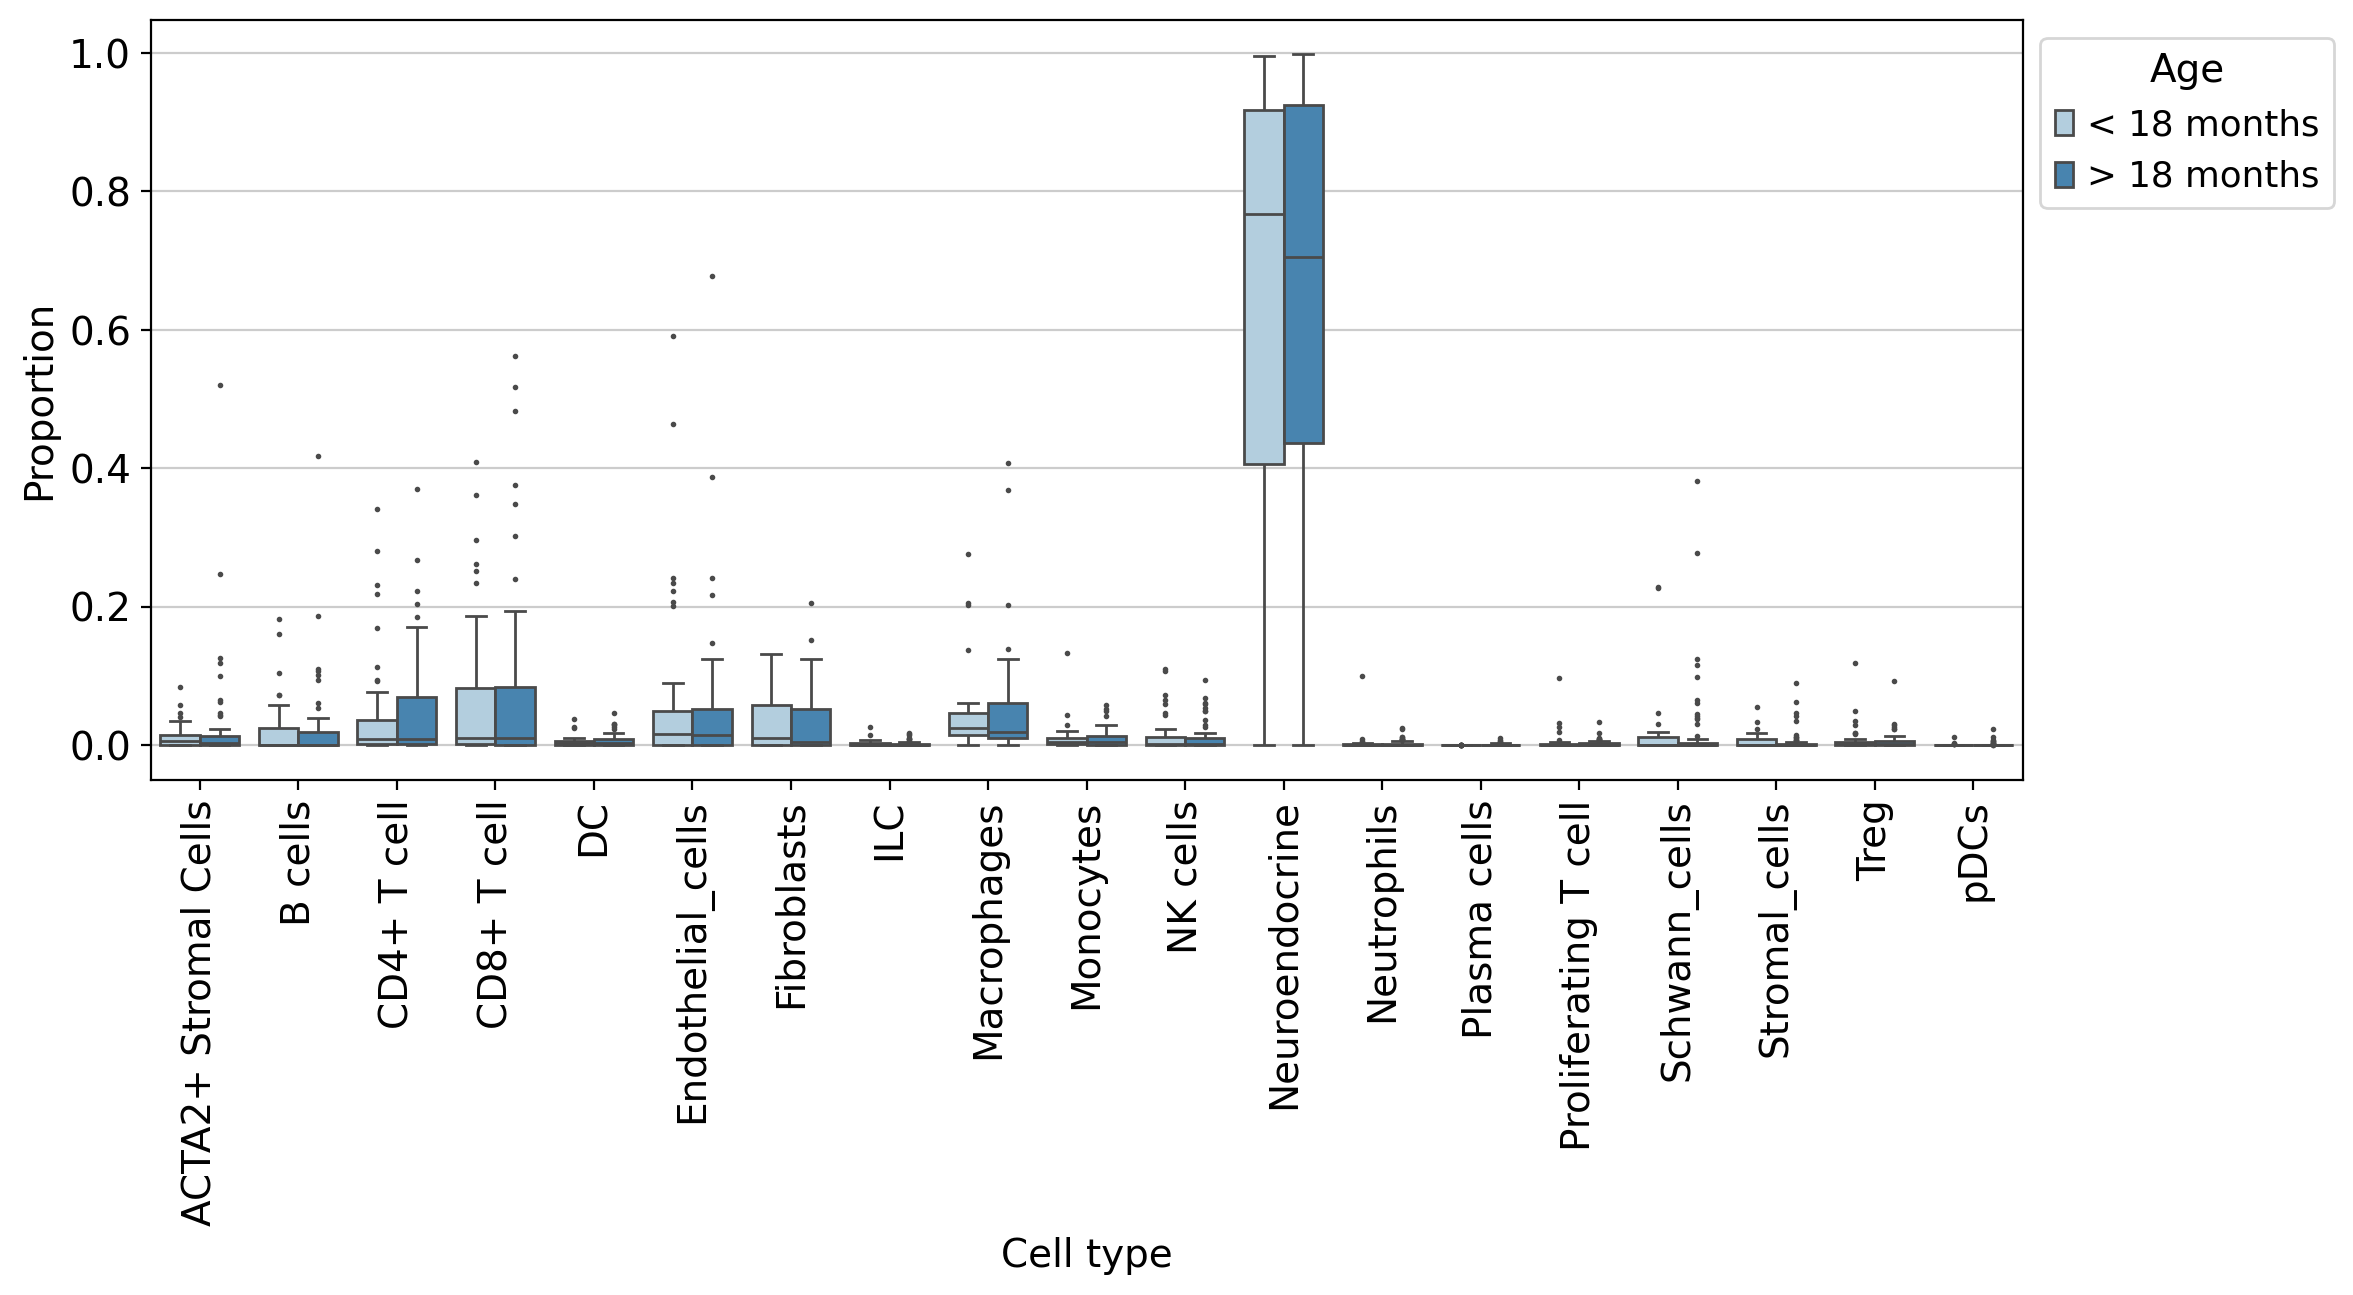

In [24]:
sccoda_model.plot_boxplots(
    sccoda_data,
    modality_key="coda",
    feature_name="Age",
    figsize=(12, 5)
)
plt.show()

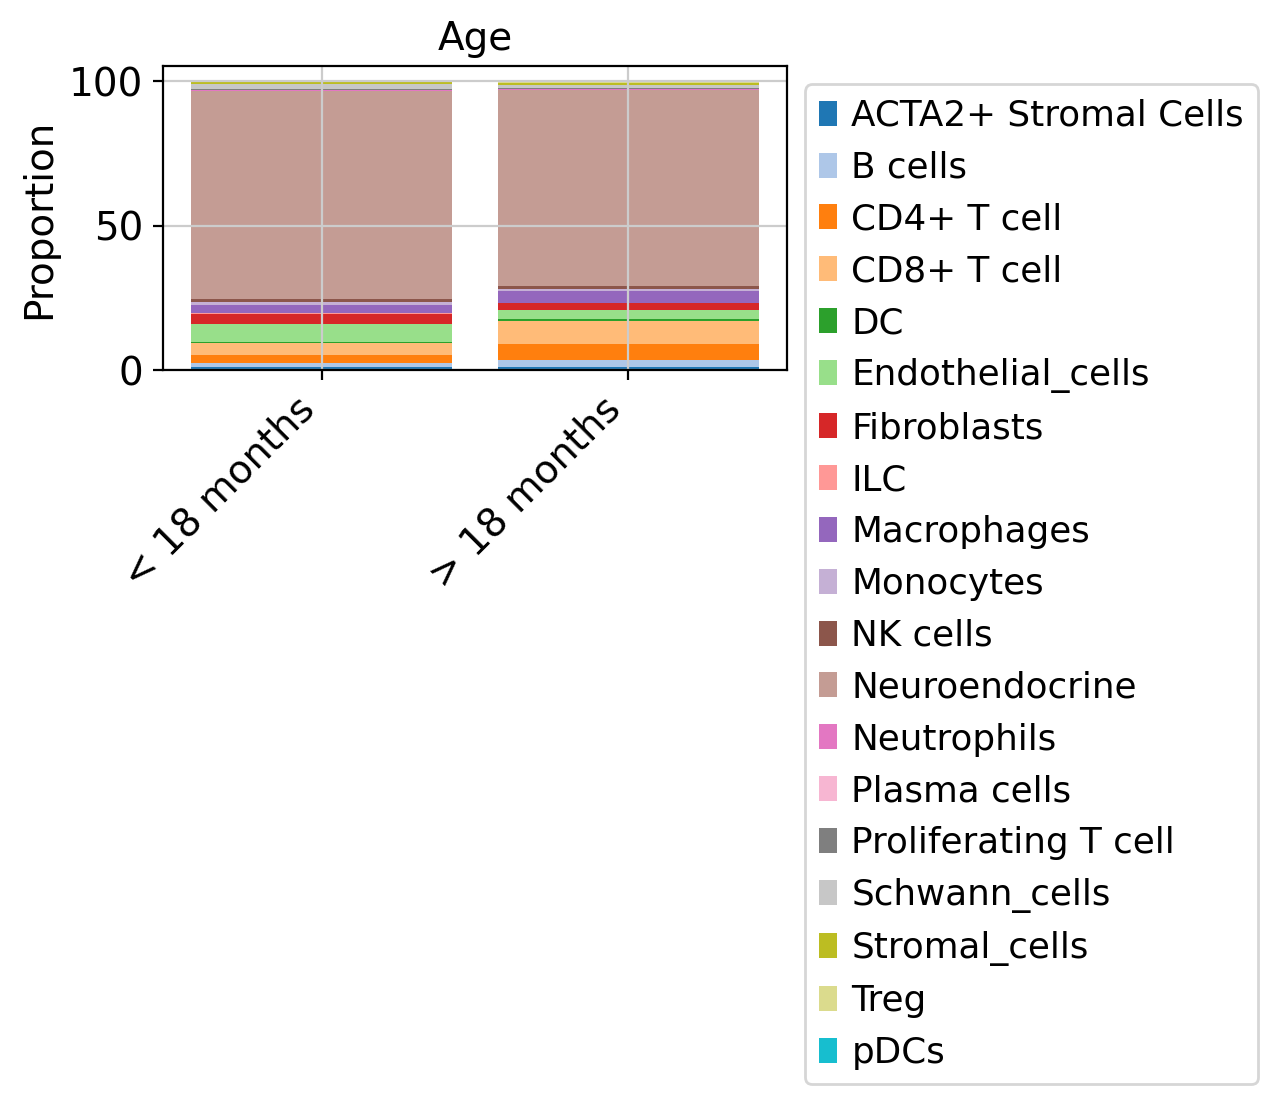

In [25]:
sccoda_model.plot_stacked_barplot(
    sccoda_data, modality_key="coda", feature_name="Age", figsize=(4, 2)
)
plt.show()

In [ ]:
sccoda_data = sccoda_model.prepare(
    sccoda_data,
    modality_key="coda",
    formula="Age + Study_method",
    reference_cell_type="automatic",
    automatic_reference_absence_threshold=0.1
)
sccoda_model.run_nuts(sccoda_data, modality_key="coda", rng_key=1234)

• Automatic reference selection! Reference cell type set to Plasma cells


warmup:   1%|█                                                                    | 164/11000 [01:01<40:34,  4.45it/s, 255 steps of size 7.43e-03. acc. prob=0.77]

In [64]:
sccoda_model.summary(sccoda_data)

/bigdata/katepetrenko/miniconda3/lib/python3.12/site-packages/pertpy/tools/_coda/_base_coda.py:840: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  effect_df.index.levels[0].str.replace("Condition", "").str.replace("[", "").str.replace("]", ""),
/bigdata/katepetrenko/miniconda3/lib/python3.12/site-packages/pertpy/tools/_coda/_base_coda.py:840: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  effect_df.index.levels[0].str.replace("Condition", "").str.replace("[", "").str.replace("]", ""),


                                          Compositional Analysis summary                                           
┌───────────────────────────────────────────┬─────────────────────────────────────────────────────────────────────┐
│ Name                                      │ Value                                                               │
├───────────────────────────────────────────┼─────────────────────────────────────────────────────────────────────┤
│ Data                                      │ Data: 103 samples, 19 cell types                                    │
│ Reference cell type                       │ Macrophages                                                         │
│ Formula                                   │ Age + Study_method                                                  │
└───────────────────────────────────────────┴─────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                       Final Parameter  Expected Sample                                                          │
│ Cell Type                                                                                                       │
│ ACTA2+ Stromal Cells      -1.062           162.055                                                              │
│ B cells                   -1.349           121.624                                                              │
│ CD4+ T cell               -0.188           388.362                                                              │
│ CD8+ T cell               -0.358           327.647                                                              │
│ DC                        -1.023           168.500                                                              │
│ Endothelial_cells         -0.949           181.442                                                              │
│ Fibroblasts               -1.042           165.329                                                              │
│ ILC                       -1.438           111.268                                                              │
│ Macrophages               -0.152           402.598                                                              │
│ Monocytes                 -0.873           195.770                                                              │
│ NK cells                  -1.131           151.251                                                              │
│ Neuroendocrine             0.959          1222.848                                                              │
│ Neutrophils               -1.332           123.710                                                              │
│ Plasma cells              -1.587            95.865                                                              │
│ Proliferating T cell      -1.326           124.454                                                              │
│ Schwann_cells             -1.498           104.788                                                              │
│ Stromal_cells             -1.391           116.622                                                              │
│ Treg                      -1.183           143.587                                                              │
│ pDCs                      -1.612            93.498                                                              │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                                  Final Parameter  Expected Sample  log2-fold change             │
│ Covariate                  Cell Type                                                                            │
│ AgeT.< 18 months           ACTA2+ Stromal Cells       0.000           162.055            0.000                  │
│                            B cells                    0.000           121.624            0.000                  │
│                            CD4+ T cell                0.000           388.362            0.000                  │
│                            CD8+ T cell                0.000           327.647            0.000                  │
│                            DC                         0.000           168.500            0.000                  │
│                            Endothelial_cells          0.000           181.442            0.000                  │
│                            Fibroblasts                0.000           165.329            0.000                  │
│                            ILC                        0.000           111.268            0.000                  │
│                            Macrophages                0.000           402.598            0.000                  │
│                            Monocytes                  0.000           195.770            0.000                  │
│                            NK cells                   0.000           151.251            0.000                  │
│                            Neuroendocrine             0.000          1222.848            0.000                  │
│                            Neutrophils                0.000           123.710            0.000                  │
│                            Plasma cells               0.000            95.865            0.000                  │
│                            Proliferating T cell       0.000           124.454            0.000                  │
│                            Schwann_cells              0.000           104.788            0.000                  │
│                            Stromal_cells              0.000           116.622            0.000                  │
│                            Treg                       0.000           143.587            0.000                  │
│                            pDCs                       0.000            93.498            0.000                  │
│ Study_methodT.bonine_sn    ACTA2+ Stromal Cells       0.000           112.765           -0.523                  │
│                            B cells                    0.000            84.631           -0.523                  │
│                            CD4+ T cell               -0.729           130.382           -1.575                  │
│                            CD8+ T cell                0.000           227.991           -0.523                  │
│                            DC                         0.000           117.250           -0.523                  │
│                            Endothelial_cells          1.041           357.581            0.979                  │
│                            Fibroblasts                0.000           115.043           -0.523                  │
│                            ILC                        0.000            77.425           -0.523                  │
│                            Macrophages                0.000           280.144           -0.523                  │
│                            Monocytes                  0.000           136.225           -0.523                  │
│                            NK cells                   

In [62]:
results_df

<bound method Sccoda.summary of <pertpy.tools._coda._sccoda.Sccoda object at 0x7feb7bbeea50>>

In [69]:
query.obs['Final_Annotation']

Tumor_10_dong_Tumor_10_dong_AAACCTGTCTTTAGTC.1                  Neuroendocrine
Tumor_10_dong_Tumor_10_dong_AAACGGGGTTTCCACC.1                  Neuroendocrine
Tumor_10_dong_Tumor_10_dong_AAAGATGCAGAGTGTG.1                  Neuroendocrine
Tumor_10_dong_Tumor_10_dong_AAAGATGGTACTTCTT.1                  Neuroendocrine
Tumor_10_dong_Tumor_10_dong_AAAGCAAAGAGCTTCT.1                  Neuroendocrine
                                                                     ...      
HTAPP_204_patel_rep1_HTAPP_204_patel_rep1_TTTGTCATCCAGTATG-1    Neuroendocrine
HTAPP_204_patel_rep1_HTAPP_204_patel_rep1_TTTGTCATCCCTAACC-1    Neuroendocrine
HTAPP_204_patel_rep1_HTAPP_204_patel_rep1_TTTGTCATCCTTGCCA-1    Neuroendocrine
HTAPP_204_patel_rep1_HTAPP_204_patel_rep1_TTTGTCATCTATGTGG-1    Neuroendocrine
HTAPP_204_patel_rep1_HTAPP_204_patel_rep1_TTTGTCATCTGATACG-1    Neuroendocrine
Name: Final_Annotation, Length: 452997, dtype: category
Categories (19, object): ['ACTA2+ Stromal Cells', 'B cells', 'CD4+ T cell',

In [70]:
cell_types = sccoda_data.mod["coda"].var.index.tolist()
results_cycle = pd.DataFrame(index=cell_types, columns=["times_credible"]).fillna(0)

for ct in cell_types:
    print(f"Testing with reference: {ct}")
    
    sccoda_data_ref = sccoda_model.prepare(
        sccoda_data.copy(),
        modality_key="coda",
        formula="Age + Study_method",
        reference_cell_type=ct
    )
    
    sccoda_model.run_nuts(sccoda_data_ref, modality_key="coda", rng_key=1234)
    
    df = sccoda_model.result_to_df(sccoda_data_ref, modality_key="coda")
    df_age = df[df["covariate"] == "Age"]
    df_age.index = df_age["cell_type"]
    
    # Count only credible changes
    results_cycle["times_credible"] += df_age["credible"].astype(int)

# Add proportion and final call
results_cycle["pct_credible"] = results_cycle["times_credible"] / len(cell_types)
results_cycle["is_credible"] = results_cycle["pct_credible"] > 0.5

print(results_cycle.sort_values("pct_credible", ascending=False))

Testing with reference: ACTA2+ Stromal Cells


/bigdata/katepetrenko/miniconda3/lib/python3.12/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/bigdata/katepetrenko/miniconda3/lib/python3.12/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)
sample: 100%|███████████████████████████████████████████████████████████████████| 11000/11000 [48:07<00:00,  3.8

AttributeError: 'Sccoda' object has no attribute 'result_to_df'

In [72]:
!pip install tf-keras

/bigdata/katepetrenko/miniconda3/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.2 MB/s eta 0:00:00a 0:00:01


In [73]:
from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz

In [74]:
# Run scCODA with each cell type as the reference
cell_types = sccoda_data.mod["coda"].var.index.tolist()
results_cycle = pd.DataFrame(index=cell_types, columns=["times_credible"]).fillna(0)

for ct in cell_types:
    print(f"Reference: {ct}")

    # Run inference
    model_temp = mod.CompositionalAnalysis(query, formula="Age + Study_method", reference_cell_type=ct)
    temp_results = model_temp.sample_hmc(num_results=20000)

    # Select credible effects
    cred_eff = temp_results.credible_effects()
    cred_eff.index = cred_eff.index.droplevel(level=0)

    # add up credible effects
    results_cycle["times_credible"] += cred_eff.astype("int")



Reference: ACTA2+ Stromal Cells


AttributeError: 'NoneType' object has no attribute 'astype'

In [79]:
mod.CompositionalAnalysis(query, formula="Age + Study_method", reference_cell_type=str(cell_types[0]))

TypeError: '<' not supported between instances of 'str' and 'int'

In [80]:
cell_types = query.var.index

In [81]:
cell_types

Index(['HES4', 'ISG15', 'AGRN', 'TNFRSF18', 'TNFRSF4', 'TAS1R3', 'MXRA8',
       'MRPL20', 'VWA1', 'MMP23B',
       ...
       'IGKV3D-20', 'IGHV3-69-1', 'IGHV3-72', 'PARAL1', 'IGLV1-41', 'IFITM5',
       'IGHEP1', 'ACTBL2', 'GAGE2A', 'LINC01834'],
      dtype='object', length=5000)

In [7]:
import pandas as pd
import numpy as np
import scanpy as sc
from sccoda.util import comp_ana as mod

# Step 1: Aggregate counts per sample × cell type
counts_df = (
    query.obs.groupby(["SampleID", "Final_Annotation"])
    .size()
    .unstack(fill_value=0)
)

# Step 2: Build new AnnData
adata_counts = sc.AnnData(X=counts_df.values)

# Step 3: Add covariates to .obs
adata_counts.obs = query.obs.drop_duplicates("SampleID").set_index("SampleID").loc[counts_df.index][["Age", "Study_method"]]

# Step 4: Add cell type names to .var
adata_counts.var_names = counts_df.columns
adata_counts.obs_names = counts_df.index

# Optional: make sure categorical variables are treated correctly
adata_counts.obs["Age"] = adata_counts.obs["Age"].astype("category")
adata_counts.obs["Study_method"] = adata_counts.obs["Study_method"].astype("category")

/bigdata/katepetrenko/miniconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:750: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    ['CH_01_grossmann', 'CH_02_grossmann', 'CH_03_grossmann', 'CH_04_grossmann', 'CH_05_grossmann']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)
/bigdata/katepetrenko/miniconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:845: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['ACTA2+ Stromal Cells', 'B cells', 'CD4+ T cell', 'CD8+ T cell', 'DC']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")
/bigdata/katepetrenko/miniconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:822: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    ['CH_01_grossmann', 'CH_02_grossmann', 'CH_03_grossmann', 'CH_04_grossmann', 'CH_05_grossmann']

    Inferred to be: categorical

 

In [8]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # ⛔ disables GPU

In [ ]:
# Step 5: Loop over each cell type as reference
cell_types = adata_counts.var_names.tolist()
results_cycle = pd.DataFrame(index=cell_types, columns=["times_credible"]).fillna(0)

In [ ]:


for ct in cell_types:
    print(f"Reference: {ct}")
    
    model_temp = mod.CompositionalAnalysis(
        adata_counts.copy(),
        formula="Age + Study_method",
        reference_cell_type=ct
    )
    
    temp_results = model_temp.sample_hmc(num_results=20000)

    # Filter only Age-related effects
    cred_eff = temp_results.credible_effects()
    print(cred_eff)
    cred_eff = cred_eff.loc[cred_eff.index.get_level_values("Covariate") == "Age"]
    cred_eff.index = cred_eff.index.droplevel("Covariate")

    print(cred_eff)
    results_cycle["times_credible"] += cred_eff.astype(int)

Reference: ACTA2+ Stromal Cells
Zero counts encountered in data! Added a pseudocount of 0.5.


/bigdata/katepetrenko/miniconda3/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/bigdata/katepetrenko/miniconda3/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:20<00:00, 76.70it/s]


In [ ]:
# Final scoring
results_cycle["pct_credible"] = results_cycle["times_credible"] / len(cell_types)
results_cycle["is_credible"] = results_cycle["pct_credible"] > 0.5

print(results_cycle.sort_values("pct_credible", ascending=False))

In [10]:
print(results_cycle.sort_values("pct_credible", ascending=False))

                      times_credible  pct_credible  is_credible
ACTA2+ Stromal Cells             NaN           NaN        False
B cells                          NaN           NaN        False
CD4+ T cell                      NaN           NaN        False
CD8+ T cell                      NaN           NaN        False
DC                               NaN           NaN        False
Endothelial_cells                NaN           NaN        False
Fibroblasts                      NaN           NaN        False
ILC                              NaN           NaN        False
Macrophages                      NaN           NaN        False
Monocytes                        NaN           NaN        False
NK cells                         NaN           NaN        False
Neuroendocrine                   NaN           NaN        False
Neutrophils                      NaN           NaN        False
Plasma cells                     NaN           NaN        False
Proliferating T cell             NaN    

In [32]:
results_cycle

,times_credible,pct_credible,is_credible
ACTA2+ Stromal Cells,0,0.000000,False
B cells,0,0.000000,False
CD4+ T cell,0,0.000000,False
CD8+ T cell,1,0.052632,False
DC,0,0.000000,False
Endothelial_cells,0,0.000000,False
Fibroblasts,0,0.000000,False
ILC,0,0.000000,False
Macrophages,0,0.000000,False
Monocytes,0,0.000000,False
